In [1]:
!nvidia-smi
!mkdir -p /etc/OpenCL/vendors
!echo "libnvidia-opencl.so.1" | tee /etc/OpenCL/vendors/nvidia.icd

!apt-get update -qq
!apt-get install -y -qq ocl-icd-libopencl1
!pip -q install -U lightgbm
import lightgbm as lgb
print("LightGBM version:", lgb.__version__)
params = {"device":"gpu", "max_bin":63, "verbosity":1}
print("GPU param set OK →", params)


Fri Aug 29 09:47:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             47W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
CANDIDATE_DATA_PATHS = [
    "predictive_maintanance.csv",
    "predictive_maintenance.csv"
]

In [3]:
import os, warnings; warnings.filterwarnings("ignore")
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from joblib import dump
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, average_precision_score, precision_recall_curve, confusion_matrix, f1_score
from sklearn.experimental import enable_halving_search_cv  # noqa: F401
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.preprocessing import MaxAbsScaler
import lightgbm



In [4]:
import os
import pandas as pd
DATA_PATH = None
for p in CANDIDATE_DATA_PATHS:
    if os.path.exists(p):
        DATA_PATH = p
        break
if DATA_PATH is None:
    raise FileNotFoundError("predictive_maintenance.csv couldn't be found")

df = pd.read_csv(DATA_PATH)

In [5]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('ggplot')

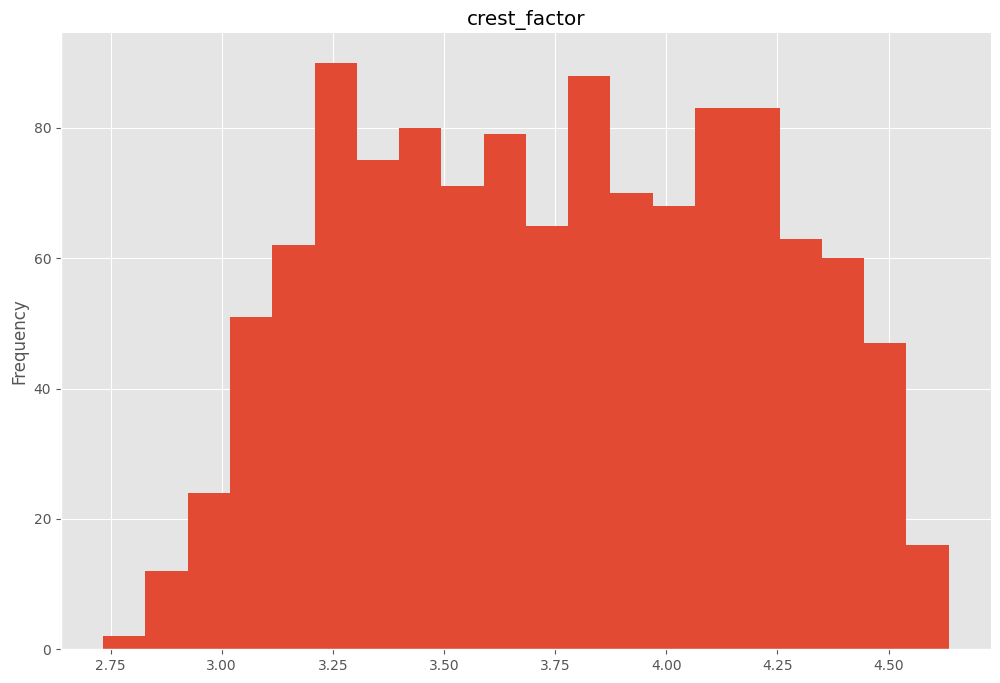

In [6]:

from matplotlib import pyplot as plt
df['crest_factor'].plot(kind='hist', bins=20, title='crest_factor')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [7]:
missing_summary = pd.DataFrame({
    'columns': df.columns,
    'missing number': df.isnull().sum(),
    'missing percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_summary = missing_summary[missing_summary['missing number'] > 0]
print(missing_summary.sort_values('missing percentage', ascending=False))


                                   columns  missing number  missing percentage
spectral_centroid_hz  spectral_centroid_hz              13                1.08
rms                                    rms              12                1.00
crest_factor                  crest_factor              11                0.92
kurtosis                          kurtosis              11                0.92
pressure_bar                  pressure_bar              11                0.92
housing_temp_c              housing_temp_c              11                0.92
condition_indicator    condition_indicator               9                0.75
vibration_rms                vibration_rms               9                0.75


In [8]:
import os, warnings; warnings.filterwarnings("ignore")
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from joblib import dump
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, average_precision_score, precision_recall_curve, confusion_matrix, f1_score


In [9]:
RNG, OUT = 42, "outputs_pm2"; np.random.seed(RNG); os.makedirs(OUT, exist_ok=True)


In [10]:
CANDS = [
  "predictive_maintenance_with_severity.csv",
  "/mnt/data/predictive_maintenance_with_severity.csv",
  "predictive_maintenance_ultra_mini.csv.gz", "predictive_maintenance_mini.csv.gz",
  "predictive_maintenance_small.csv",
  "/mnt/data/predictive_maintenance_ultra_mini.csv.gz", "/mnt/data/predictive_maintenance_mini.csv.gz",
  "predictive_maintenance.csv",
]
DATA = next((p for p in CANDS if os.path.exists(p)), None)
if not DATA: raise FileNotFoundError("Predictive Maintenance data not found.")
df = pd.read_csv(DATA)
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df = df.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)
print(f"[INFO] Loaded {DATA} | rows={len(df)} cols={len(df.columns)}")


[INFO] Loaded predictive_maintenance.csv | rows=1200 cols=17


In [11]:
df.head(15)

,timestamp,machine_id,time_to_failure,y_cls_early_window,cls_weight_early,y_awareness_45,condition_indicator,severity,rms,kurtosis,crest_factor,spectral_centroid_hz,housing_temp_c,vibration_rms,pressure_bar,is_anomaly,fault
0,2025-01-01 08:00:00,M1,200.0,0,1.0,0,0.014901,Low,0.493087,2.864769,3.152303,198.829233,34.882932,0.247376,2.315349,0,0
1,2025-01-01 08:01:00,M1,199.0,0,1.0,0,0.000000,Low,0.477886,2.702717,3.038925,196.209880,34.353848,0.248469,2.293984,0,0
2,2025-01-01 08:02:00,M1,198.0,0,1.0,0,0.000000,Low,0.497415,2.747829,3.200228,201.432514,34.591145,0.233676,2.272583,0,0
3,2025-01-01 08:03:00,M1,197.0,0,1.0,0,0.037154,Low,0.526568,2.800435,2.992390,194.857390,34.820078,0.199681,2.316642,0,0
4,2025-01-01 08:04:00,M1,196.0,0,1.0,0,0.050930,Low,0.570564,2.732078,2.999079,204.656317,35.727773,0.203625,2.290287,0,0
5,2025-01-01 08:05:00,M1,195.0,0,1.0,0,0.035842,Low,0.606902,2.816417,3.193964,190.651274,35.710951,0.225111,2.286520,0,0
6,2025-01-01 08:06:00,M1,194.0,0,1.0,0,0.005745,Low,0.510912,2.915540,3.077875,201.851199,35.616634,0.229912,2.310373,0,0
7,2025-01-01 08:07:00,M1,193.0,0,1.0,0,0.035153,Low,0.530271,2.686463,3.010435,203.536427,35.018861,0.226661,2.297581,0,0
8,2025-01-01 08:08:00,M1,192.0,0,1.0,0,0.041807,Low,0.671162,2.812764,3.090155,205.826441,34.895661,0.270285,2.303039,0,0
9,2025-01-01 08:09:00,M1,191.0,0,1.0,0,0.015284,Low,0.525685,2.845965,3.017152,198.996683,35.574281,0.208631,2.295972,0,0


In [12]:
df = df.drop(columns=[
    "time_to_failure",
    "y_cls_early_window",
    "cls_weight_early",
    "y_awareness_45"
], errors="ignore")


In [13]:
df["next_fault_ts"] = df.groupby("machine_id")["timestamp"].transform(
    lambda ts: ts.where(df["fault"] == 1).fillna(pd.NaT).iloc[::-1].ffill().iloc[::-1]
)
df["time_to_failure"] = (df["next_fault_ts"] - df["timestamp"]).dt.total_seconds() / 60

df["y_cls_early_window"] = ((df["time_to_failure"] >= 0) & (df["time_to_failure"] <= 60)).astype(int)
df["y_awareness_45"] = ((df["time_to_failure"] >= 0) & (df["time_to_failure"] <= 45)).astype(int)

y = df["y_cls_early_window"].dropna().astype(int)




In [14]:
neg, pos = (y == 0).sum(), (y == 1).sum()


In [15]:
print("Negativ number", neg)
print("Pozitiv number", pos)


Negativ number 1017
Pozitiv number 183


In [16]:
w_pos = neg / max(pos, 1)


In [17]:
w_pos

np.float64(5.557377049180328)

In [18]:
df["cls_weight_early"] = np.where(df["y_cls_early_window"] == 1, w_pos, 1.0)


In [19]:
REGR_TARGET, CLF_TARGET = "time_to_failure", "y_cls_early_window"
WEIGHT_COL,  AWARENESS  = "cls_weight_early", "y_awareness_45"
for c in (REGR_TARGET, CLF_TARGET, WEIGHT_COL):
    if c not in df.columns: raise ValueError(f"Missing column: {c}")
ban = [c for c in ["timestamp","split","machine_id","is_anomaly",REGR_TARGET,CLF_TARGET,AWARENESS,"fault",WEIGHT_COL] if c in df.columns]


In [20]:
df.value_counts()

,,,,,,,,,,,,,,,,,,count
timestamp,machine_id,condition_indicator,severity,rms,kurtosis,crest_factor,spectral_centroid_hz,housing_temp_c,vibration_rms,pressure_bar,is_anomaly,fault,next_fault_ts,time_to_failure,y_cls_early_window,y_awareness_45,cls_weight_early,
2025-01-02 00:40:00,M3,0.000000,Low,0.532604,2.883923,2.779172,196.737010,36.158758,0.217502,2.313522,0,1,2025-01-02 00:40:00,0.0,1,1,5.557377,1
2025-01-01 08:00:00,M1,0.014901,Low,0.493087,2.864769,3.152303,198.829233,34.882932,0.247376,2.315349,0,0,2025-01-01 11:20:00,200.0,0,0,1.000000,1
2025-01-01 08:01:00,M1,0.000000,Low,0.477886,2.702717,3.038925,196.209880,34.353848,0.248469,2.293984,0,0,2025-01-01 11:20:00,199.0,0,0,1.000000,1
2025-01-01 08:02:00,M1,0.000000,Low,0.497415,2.747829,3.200228,201.432514,34.591145,0.233676,2.272583,0,0,2025-01-01 11:20:00,198.0,0,0,1.000000,1
2025-01-01 08:03:00,M1,0.037154,Low,0.526568,2.800435,2.992390,194.857390,34.820078,0.199681,2.316642,0,0,2025-01-01 11:20:00,197.0,0,0,1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-01 08:22:00,M1,0.130459,Low,0.616487,2.920417,3.151986,216.984980,36.617579,0.274453,2.308848,0,0,2025-01-01 11:20:00,178.0,0,0,1.000000,1
2025-01-01 08:23:00,M1,0.117274,Low,0.604142,2.989512,3.157794,213.122514,36.219307,0.315888,2.254226,0,0,2025-01-01 11:20:00,177.0,0,0,1.000000,1
2025-01-01 08:24:00,M1,0.076557,Low,0.573627,2.824156,3.158655,219.554538,37.177678,0.333730,2.260801,0,0,2025-01-01 11:20:00,176.0,0,0,1.000000,1


In [21]:
df.severity.value_counts()

,count
severity,
High,405
Low,401
Medium,394


In [22]:
df.condition_indicator.value_counts()

,count
condition_indicator,
0.000000,23
1.000000,11
0.034995,1
0.079224,1
0.021112,1
...,...
0.918506,1
0.945767,1
0.948272,1


In [23]:
df["cond_band"] = pd.cut(
    df["condition_indicator"],
    bins=[-np.inf, 0.33, 0.66, np.inf],
    labels=["Low", "Medium", "High"],
    include_lowest=True
).astype(df['severity'].dtype)

df["same"] = df["severity"] == df["cond_band"]
print(df["same"].value_counts())

same
True     1191
False       9
Name: count, dtype: int64


In [24]:
df = df.drop(columns=["cond_band"])
df = df.drop(columns=["condition_indicator"])
df = df.drop(columns=["same"])

In [25]:
df.value_counts()

,,,,,,,,,,,,,,,,,count
timestamp,machine_id,severity,rms,kurtosis,crest_factor,spectral_centroid_hz,housing_temp_c,vibration_rms,pressure_bar,is_anomaly,fault,next_fault_ts,time_to_failure,y_cls_early_window,y_awareness_45,cls_weight_early,
2025-01-02 00:40:00,M3,Low,0.532604,2.883923,2.779172,196.737010,36.158758,0.217502,2.313522,0,1,2025-01-02 00:40:00,0.0,1,1,5.557377,1
2025-01-01 08:00:00,M1,Low,0.493087,2.864769,3.152303,198.829233,34.882932,0.247376,2.315349,0,0,2025-01-01 11:20:00,200.0,0,0,1.000000,1
2025-01-01 08:01:00,M1,Low,0.477886,2.702717,3.038925,196.209880,34.353848,0.248469,2.293984,0,0,2025-01-01 11:20:00,199.0,0,0,1.000000,1
2025-01-01 08:02:00,M1,Low,0.497415,2.747829,3.200228,201.432514,34.591145,0.233676,2.272583,0,0,2025-01-01 11:20:00,198.0,0,0,1.000000,1
2025-01-01 08:03:00,M1,Low,0.526568,2.800435,2.992390,194.857390,34.820078,0.199681,2.316642,0,0,2025-01-01 11:20:00,197.0,0,0,1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-01 08:27:00,M1,Low,0.686596,2.775977,3.385646,226.147201,36.385412,0.270106,2.286577,0,0,2025-01-01 11:20:00,173.0,0,0,1.000000,1
2025-01-01 08:28:00,M1,Low,0.670349,2.866993,3.272285,215.661898,36.608810,0.329609,2.268289,0,0,2025-01-01 11:20:00,172.0,0,0,1.000000,1
2025-01-01 08:29:00,M1,Low,0.677376,3.122075,3.393034,220.505179,37.225785,0.349861,2.283873,0,0,2025-01-01 11:20:00,171.0,0,0,1.000000,1


In [26]:
ord_cols, ord_cats = [], []
if "severity" in df.columns:
    df["severity"] = df["severity"].astype(str).str.title()
    df.loc[~df["severity"].isin({"Low","Medium","High"}), "severity"] = np.nan
    df["severity"] = df["severity"].astype("category")
    ord_cols, ord_cats = ["severity"], [["Low","Medium","High"]]
else:
    print("[WARN] No severity/condition_indicator → continue without ordinal feature")


In [27]:
print(ord_cols)
print(ord_cats)

['severity']
[['Low', 'Medium', 'High']]


In [28]:
df_reg = df.dropna(subset=[REGR_TARGET]).reset_index(drop=True)
X_reg  = df_reg.drop(columns=ban, errors="ignore"); y_reg = df_reg[REGR_TARGET].values
df_clf = df.dropna(subset=[CLF_TARGET]).reset_index(drop=True)
X_clf  = df_clf.drop(columns=ban, errors="ignore"); y_clf = df_clf[CLF_TARGET].astype(int).values
w_clf  = df_clf[WEIGHT_COL].values if WEIGHT_COL in df_clf.columns else None


In [29]:
print(f"those which will be regretted  \n {df_reg.columns} {X_reg.columns,}")
print(f"those which will be classified \n {df_clf.columns} {X_clf.columns} {w_clf}")

those which will be regretted  
 Index(['timestamp', 'machine_id', 'severity', 'rms', 'kurtosis',
       'crest_factor', 'spectral_centroid_hz', 'housing_temp_c',
       'vibration_rms', 'pressure_bar', 'is_anomaly', 'fault', 'next_fault_ts',
       'time_to_failure', 'y_cls_early_window', 'y_awareness_45',
       'cls_weight_early'],
      dtype='object') (Index(['severity', 'rms', 'kurtosis', 'crest_factor', 'spectral_centroid_hz',
       'housing_temp_c', 'vibration_rms', 'pressure_bar', 'next_fault_ts'],
      dtype='object'),)
those which will be classified 
 Index(['timestamp', 'machine_id', 'severity', 'rms', 'kurtosis',
       'crest_factor', 'spectral_centroid_hz', 'housing_temp_c',
       'vibration_rms', 'pressure_bar', 'is_anomaly', 'fault', 'next_fault_ts',
       'time_to_failure', 'y_cls_early_window', 'y_awareness_45',
       'cls_weight_early'],
      dtype='object') Index(['severity', 'rms', 'kurtosis', 'crest_factor', 'spectral_centroid_hz',
       'housing_temp_c', 

In [30]:
X_all  = df.drop(columns=ban, errors="ignore")
num    = X_all.select_dtypes(include=["int64","float64"]).columns.tolist()
cat    = X_all.select_dtypes(include=["object","category","bool"]).columns.tolist()
cat_no = [c for c in cat if c not in ord_cols]

for c in num:
    df[c] = pd.to_numeric(df[c], errors="coerce").astype("float32")



In [31]:
num

['rms',
 'kurtosis',
 'crest_factor',
 'spectral_centroid_hz',
 'housing_temp_c',
 'vibration_rms',
 'pressure_bar']

In [32]:
cat

['severity']

In [33]:
try:
    ohe = OneHotEncoder(drop="first", sparse_output=True, handle_unknown="ignore")
except TypeError:
    ohe = OneHotEncoder(drop="first", sparse=True, handle_unknown="ignore")


In [34]:
ord_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("enc", OrdinalEncoder(categories=ord_cats, handle_unknown="use_encoded_value", unknown_value=-1))
]) if ord_cols else "drop"

num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc",  MaxAbsScaler())
])

cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
]) if cat_no else "drop"

In [35]:
prep = ColumnTransformer([
    ("ord", ord_pipe, ord_cols) if ord_cols else ("ord","drop",[]),
    ("num", num_pipe, [c for c in num if c not in ord_cols]),
    ("cat", cat_pipe, cat_no),
], remainder="drop")


In [36]:
tscv3 = TimeSeriesSplit(n_splits=3)

base_reg = LGBMRegressor(random_state=RNG, n_jobs=1)
base_clf = LGBMClassifier(random_state=RNG, n_jobs=1)

GPU = True
try:
    if GPU:
        base_reg = LGBMRegressor(random_state=RNG, n_jobs=1, device="gpu", max_bin=63)
        base_clf = LGBMClassifier(random_state=RNG, n_jobs=1, device="gpu", max_bin=63)
except TypeError:
    if GPU:
        base_reg = LGBMRegressor(random_state=RNG, n_jobs=1, device_type="gpu", max_bin=63)
        base_clf = LGBMClassifier(random_state=RNG, n_jobs=1, device_type="gpu", max_bin=63)

pipe_reg = Pipeline([("prep", prep), ("m", base_reg)], memory=None)
pipe_clf = Pipeline([("prep", prep), ("m", base_clf)], memory=None)

dist = {
    "m__learning_rate":     [0.03, 0.05, 0.1],
    "m__num_leaves":        [31, 63, 127],
    "m__max_depth":         [-1, 8, 12],
    "m__min_child_samples": [10, 20, 40],
    "m__subsample":         [0.7, 0.85, 1.0],
    "m__colsample_bytree":  [0.7, 0.85, 1.0],
}


#in kfold vs time series kfold causes shuffle and d leakage

reg_search = HalvingRandomSearchCV(
    pipe_reg, dist, factor=3, resource="m__n_estimators",
    min_resources=200, max_resources=3000,
    scoring="neg_mean_absolute_error", cv=tscv3,
    n_jobs=-1, aggressive_elimination=True, random_state=RNG, verbose=0
)
clf_search = HalvingRandomSearchCV(
    pipe_clf, dist, factor=3, resource="m__n_estimators",
    min_resources=200, max_resources=3000,
    scoring="average_precision", cv=tscv3,
    n_jobs=-1, aggressive_elimination=True, random_state=RNG, verbose=0
)

reg_search.fit(X_reg, y_reg)

fit_kwargs = {}
if 'w_clf' in locals() and w_clf is not None:
    fit_kwargs["m__sample_weight"] = w_clf
clf_search.fit(X_clf, y_clf, **fit_kwargs)

best_reg = reg_search.best_params_
best_clf = clf_search.best_params_

def pick(best, pfx):
    g = lambda k, dv: best.get(f"{pfx}{k}", dv)
    kw = dict(
        n_estimators=g("n_estimators",2000),
        learning_rate=g("learning_rate",0.05),
        num_leaves=g("num_leaves",63),
        max_depth=g("max_depth",-1),
        min_child_samples=g("min_child_samples",20),
        subsample=g("subsample",0.8),
        colsample_bytree=g("colsample_bytree",0.8),
        random_state=RNG,
        n_jobs=-1
    )
    if GPU:
        try: kw.update({"device":"gpu", "max_bin":63})
        except: kw.update({"device_type":"gpu", "max_bin":63})
    return kw

reg_kw, clf_kw = pick(best_reg,"m__"), pick(best_clf,"m__")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 444
[LightGBM] [Info] Number of data points in the train set: 603, number of used features: 8
[LightGBM] [Info] Using GPU Device: NVIDIA A100-SXM4-40GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.00 MB) transferred to GPU in 0.000246 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 100.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

In [37]:
def MAPE(y, yhat, eps=1e-6):
  return float(np.mean(np.abs((y - yhat)/np.clip(np.abs(y),eps,None)))*100)

#mutdeg=absolutev


In [38]:

# r.kfold vs tss ,
tscv5 = TimeSeriesSplit(n_splits=5); prep_only = Pipeline([("prep", prep)])
mae, mape, last_reg = [], [], None
for tr, te in tscv5.split(X_reg):
    Xtr, Xte, ytr, yte = X_reg.iloc[tr], X_reg.iloc[te], y_reg[tr], y_reg[te]
    Ztr, Zte = prep_only.fit_transform(Xtr), prep_only.transform(Xte)
    reg = LGBMRegressor(**reg_kw).fit(Ztr, ytr); yhat = reg.predict(Zte)
    mae.append(mean_absolute_error(yte, yhat)); mape.append(MAPE(yte, yhat)); last_reg = (yte, yhat)
print("[REG] MAE:", [round(v,4) for v in mae], "mean:", round(float(np.mean(mae)),4))
print("[REG] MAPE:", [round(v,2) for v in mape], "mean:", round(float(np.mean(mape)),2), "%")


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

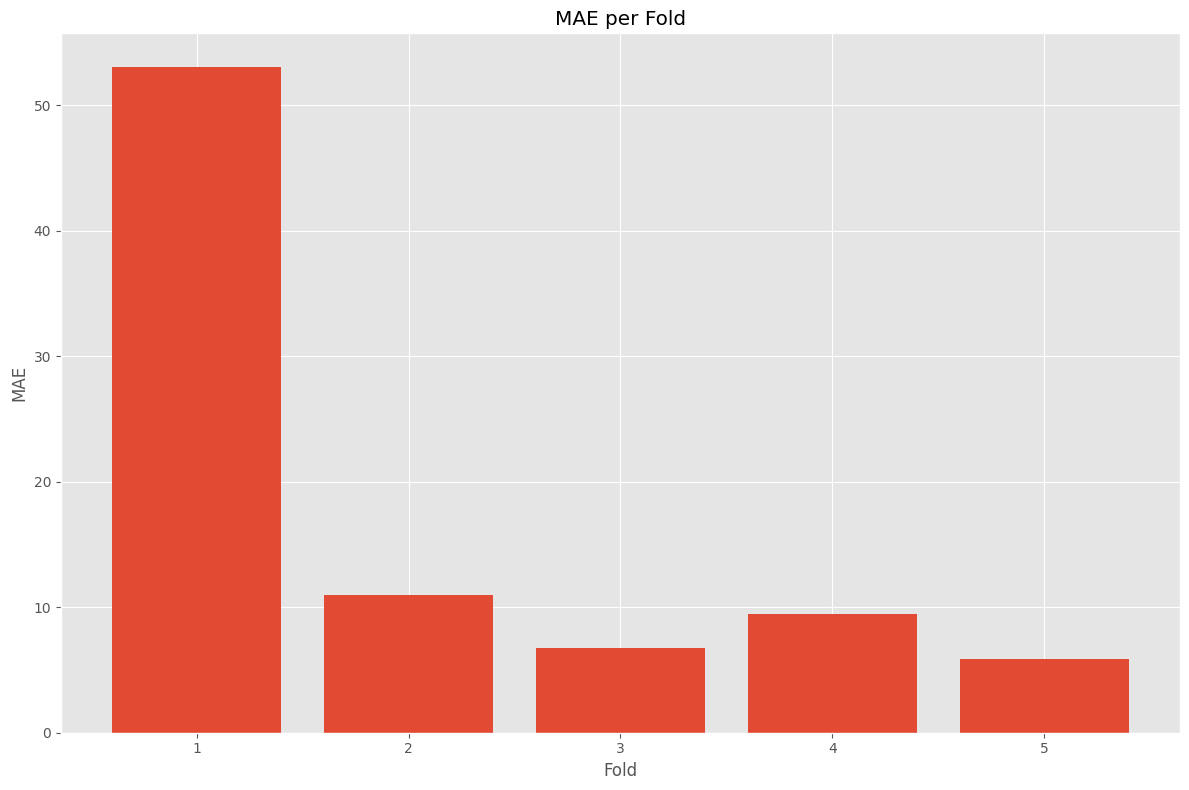

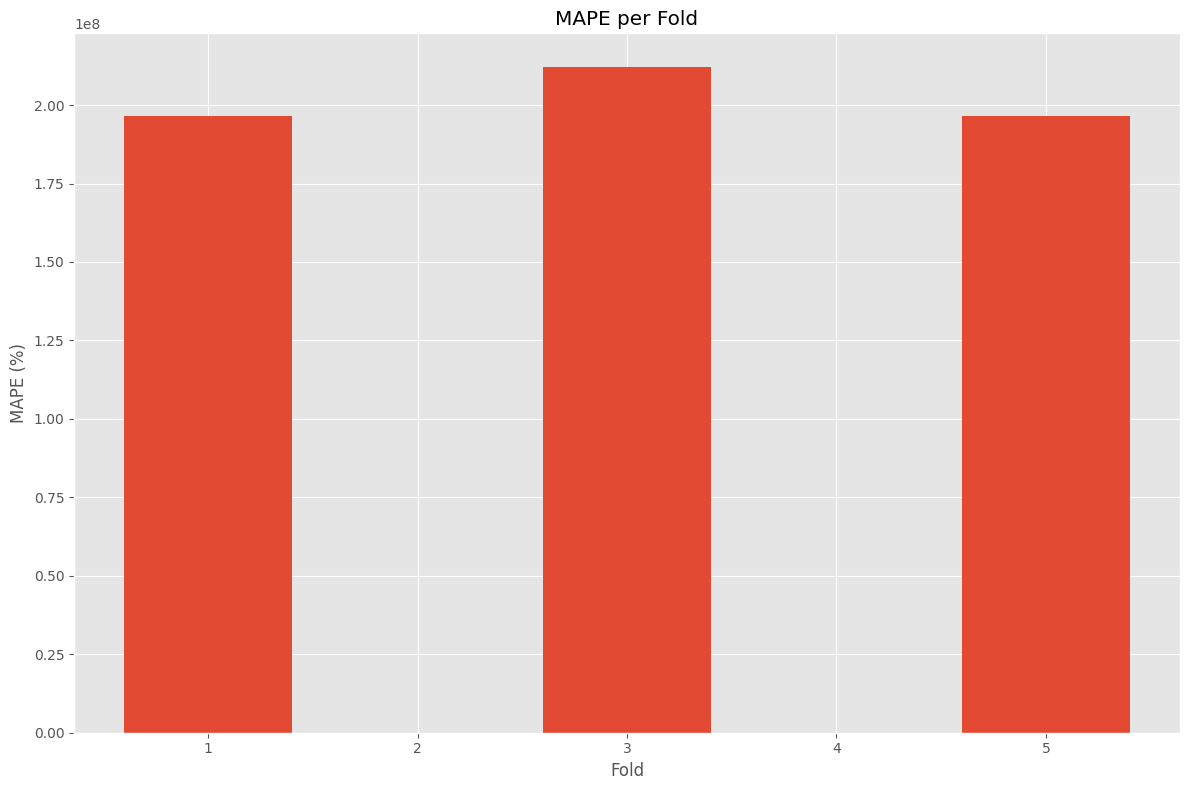

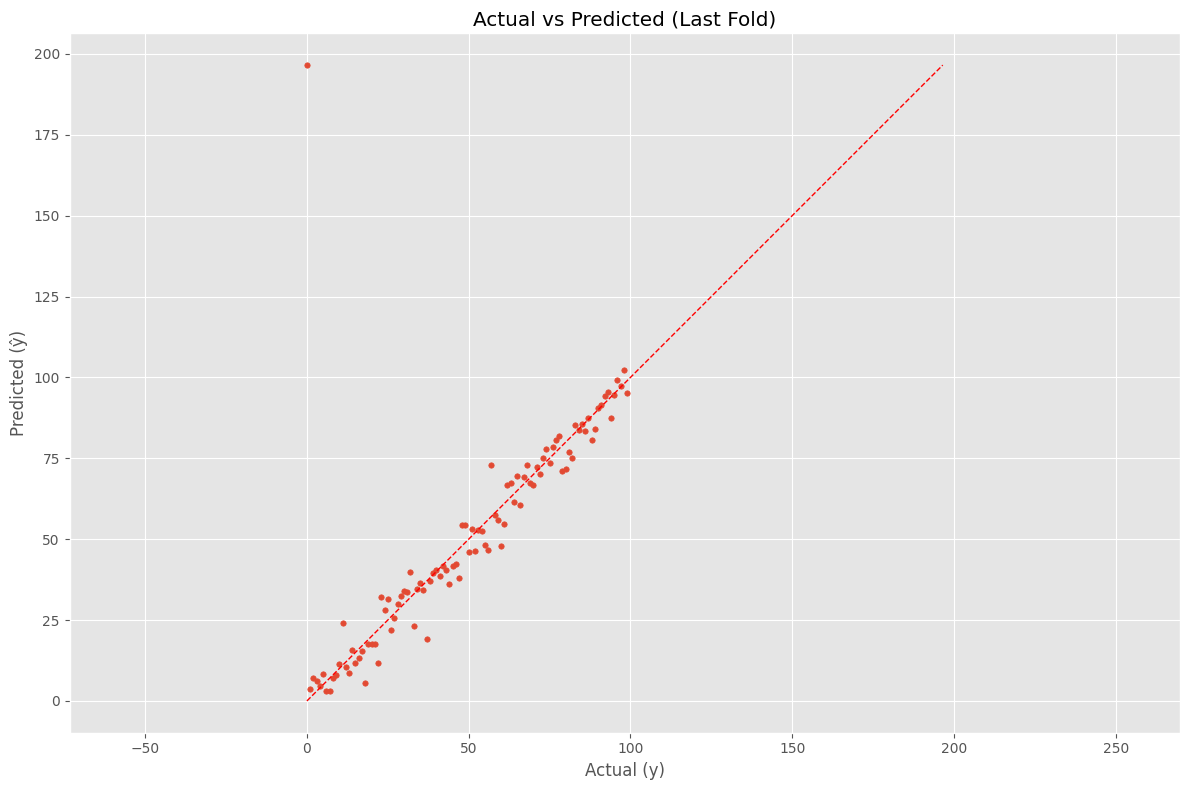

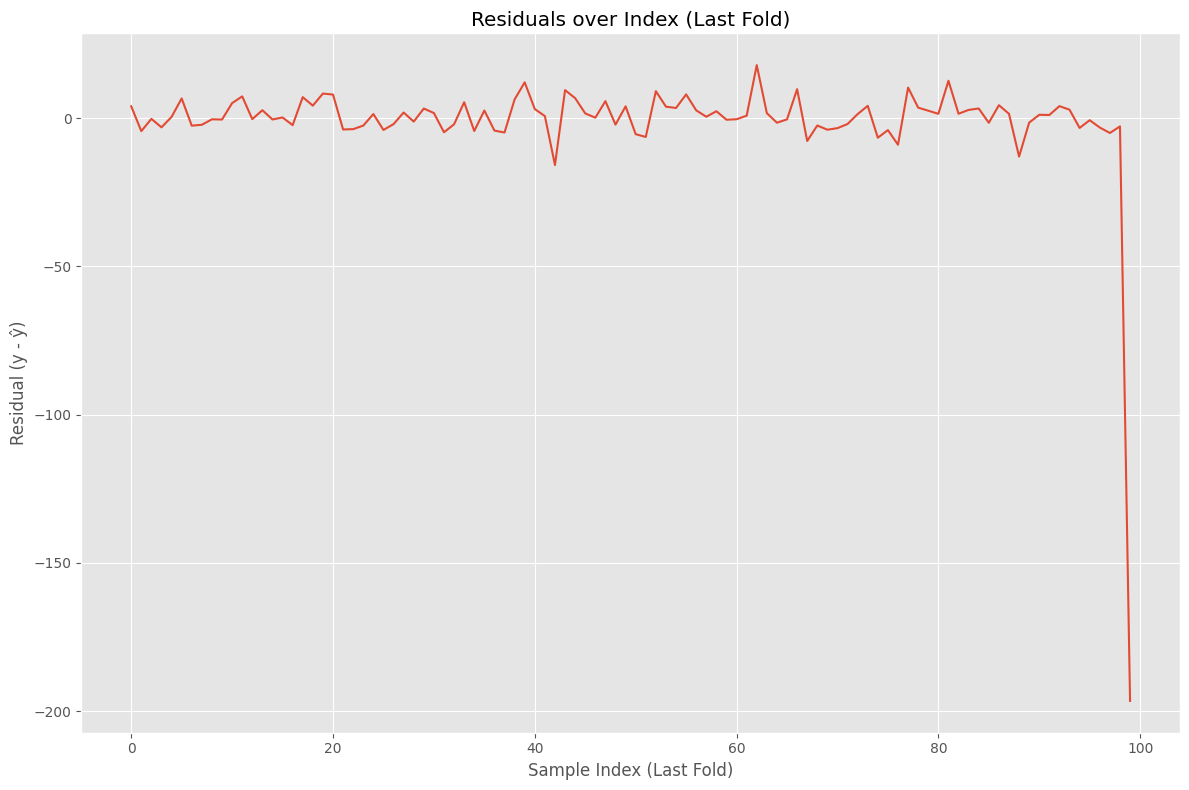

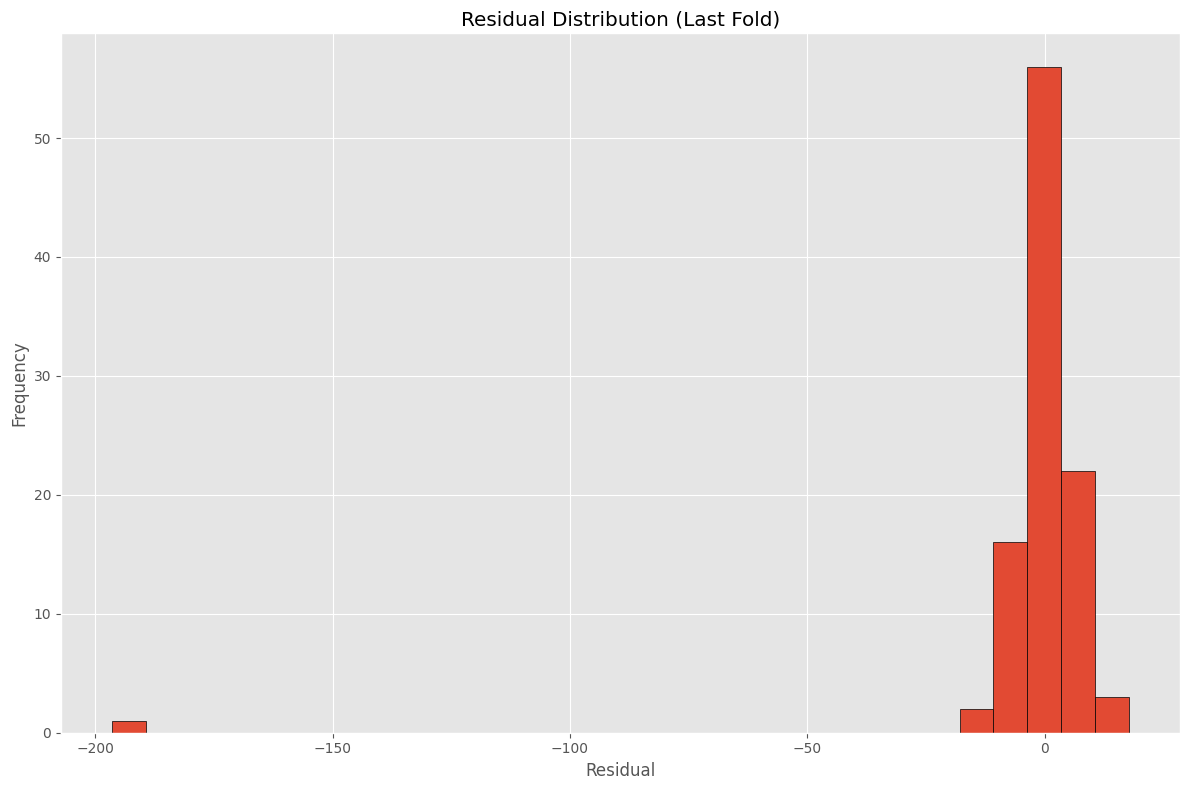

In [39]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
plt.bar(range(1, len(mae)+1), mae)
plt.xlabel("Fold")
plt.ylabel("MAE")
plt.title("MAE per Fold")
plt.tight_layout()
plt.savefig("mae_per_fold.png")
plt.show()
plt.close()

plt.figure()
plt.bar(range(1, len(mape)+1), mape)
plt.xlabel("Fold")
plt.ylabel("MAPE (%)")
plt.title("MAPE per Fold")
plt.tight_layout()
plt.savefig("mape_per_fold.png")
plt.show()
plt.close()

y_true, y_pred = last_reg
y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)

plt.figure()
plt.scatter(y_true, y_pred, s=15)
mn, mx = np.nanmin([y_true.min(), y_pred.min()]), np.nanmax([y_true.max(), y_pred.max()])
plt.plot([mn, mx], [mn, mx], "r--", linewidth=1)
plt.xlabel("Actual (y)")
plt.ylabel("Predicted (ŷ)")
plt.title("Actual vs Predicted (Last Fold)")
plt.axis("equal")
plt.tight_layout()
plt.savefig("höchste and niedrigste difference between actual_vs_predicted.png")
plt.show()
plt.close()

residuals = y_true - y_pred
plt.figure()
plt.plot(residuals)
plt.xlabel("Sample Index (Last Fold)")
plt.ylabel("Residual (y - ŷ)")
plt.title("Residuals over Index (Last Fold)")
plt.tight_layout()
plt.savefig("residuals_over_index.png")
plt.show()
plt.close()

plt.figure()
plt.hist(residuals, bins=30, edgecolor="black")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Residual Distribution (Last Fold)")
plt.tight_layout()
plt.savefig("residuals_histogram.png")
plt.show()
plt.close()


In [40]:
ap, f1s, last_clf = [], [], None
for tr, te in tscv3.split(X_clf):
    Xtr, Xte = X_clf.iloc[tr], X_clf.iloc[te]
    ytr, yte = y_clf[tr], y_clf[te]
    wtr = None if w_clf is None else w_clf[tr]

    Ztr = prep_only.fit_transform(Xtr)
    Zte = prep_only.transform(Xte)

    clf = LGBMClassifier(**clf_kw)
    clf.fit(
        Ztr, ytr,
        sample_weight=wtr,
        eval_set=[(Zte, yte)],
        eval_metric="binary_logloss",
        callbacks=[lightgbm.early_stopping(stopping_rounds=100, verbose=False)]
    )

    proba = clf.predict_proba(Zte, num_iteration=clf.best_iteration_)[:, 1]
    ap.append(average_precision_score(yte, proba))

    y05 = (proba >= 0.5).astype(int)
    f1s.append(f1_score(yte, y05))

    prec, rec, thr = precision_recall_curve(yte, proba)
    last_clf = (yte, proba, prec, rec, thr)

print("[CLF] PR-AUC:", [round(v, 4) for v in ap], "mean:", round(float(np.mean(ap)), 4))
print("[CLF] F1@0.5:", [round(v, 3) for v in f1s], "mean:", round(float(np.mean(f1s)), 3))


[LightGBM] [Info] Number of positive: 61, number of negative: 239
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 444
[LightGBM] [Info] Number of data points in the train set: 300, number of used features: 8
[LightGBM] [Info] Using GPU Device: NVIDIA A100-SXM4-40GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.00 MB) transferred to GPU in 0.000496 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.586505 -> initscore=0.349537
[LightGBM] [Info] Start training from score 0.349537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [41]:
COST_FN, COST_FP = 5.0, 1.0
yL, pL, P, R, T = last_clf
ths = np.r_[0.0, T, 1.0]; best_thr, best_cost = 0.5, float("inf")
for t in ths:
    yhat = (pL>=t).astype(int)
    TP = np.sum((yL==1)&(yhat==1)); FP = np.sum((yL==0)&(yhat==1)); FN = np.sum((yL==1)&(yhat==0))
    cost = COST_FN*FN + COST_FP*FP
    if cost < best_cost: best_cost, best_thr = cost, float(t)
print(f"[THR] best={best_thr:.4f} | min_cost={best_cost:.2f} (FN={COST_FN}, FP={COST_FP})")


[THR] best=0.1153 | min_cost=72.00 (FN=5.0, FP=1.0)


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 444
[LightGBM] [Info] Number of data points in the train set: 603, number of used features: 8
[LightGBM] [Info] Using GPU Device: NVIDIA A100-SXM4-40GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.00 MB) transferred to GPU in 0.000463 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 100.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

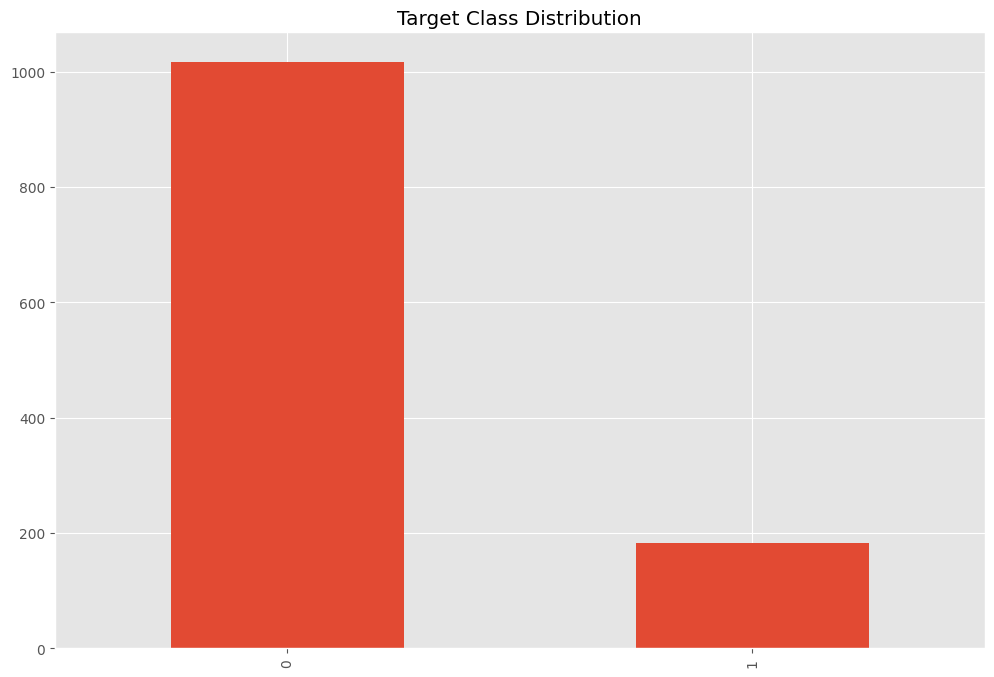

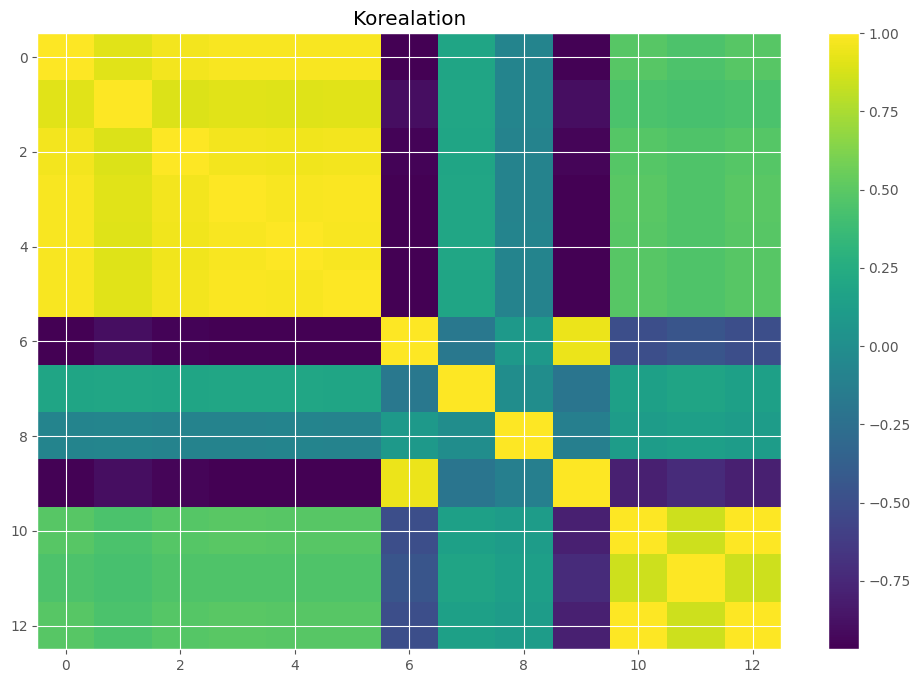

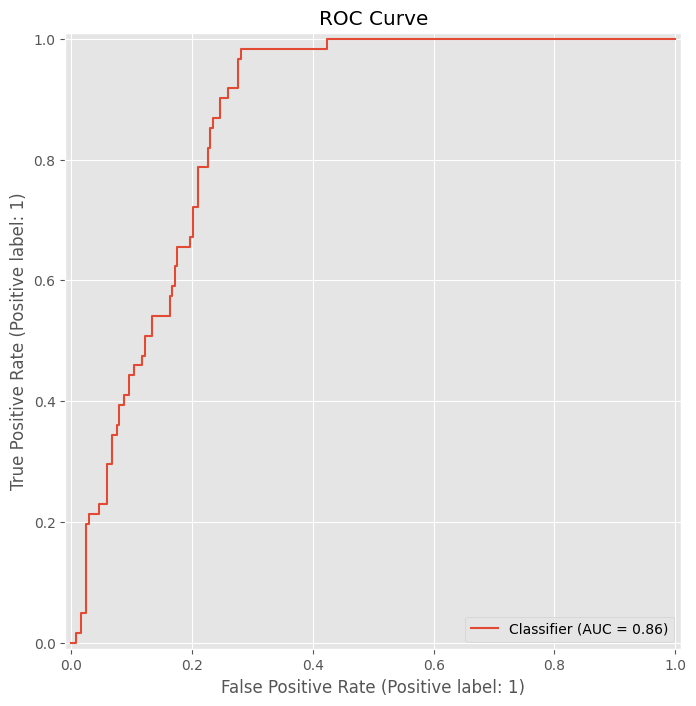

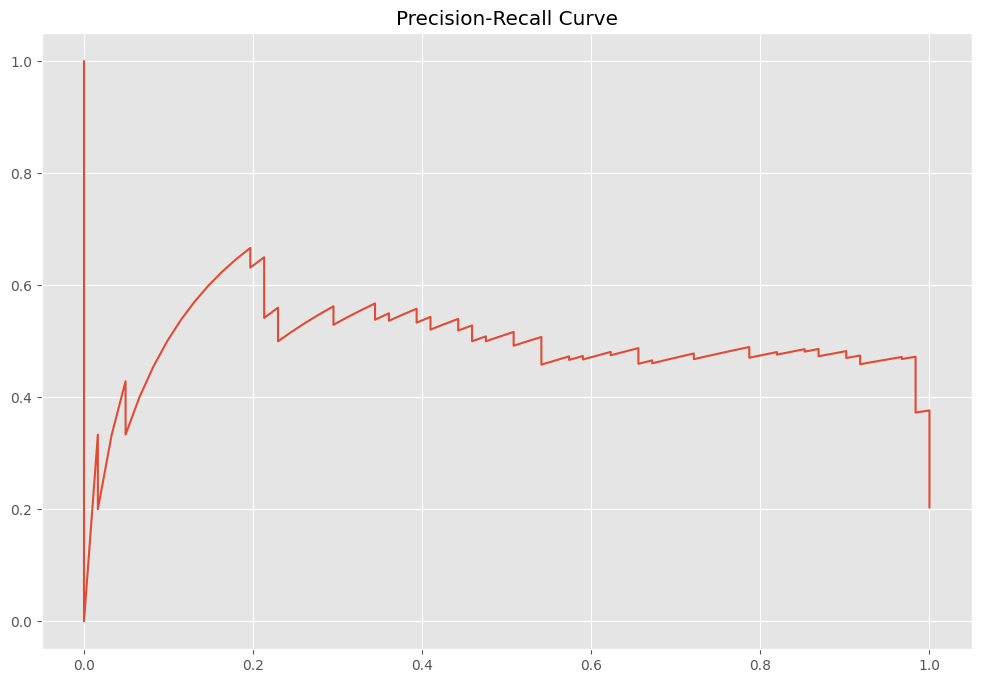

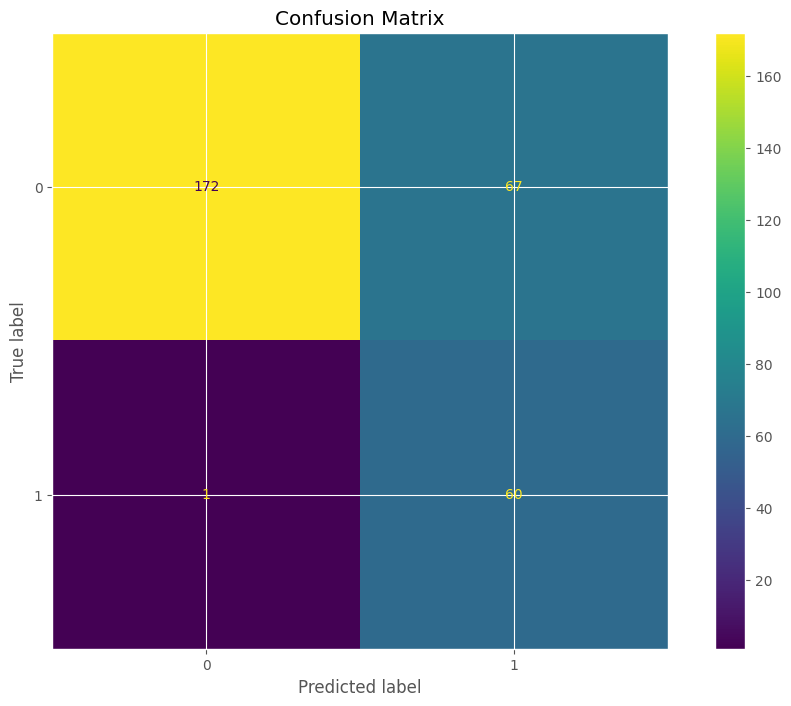

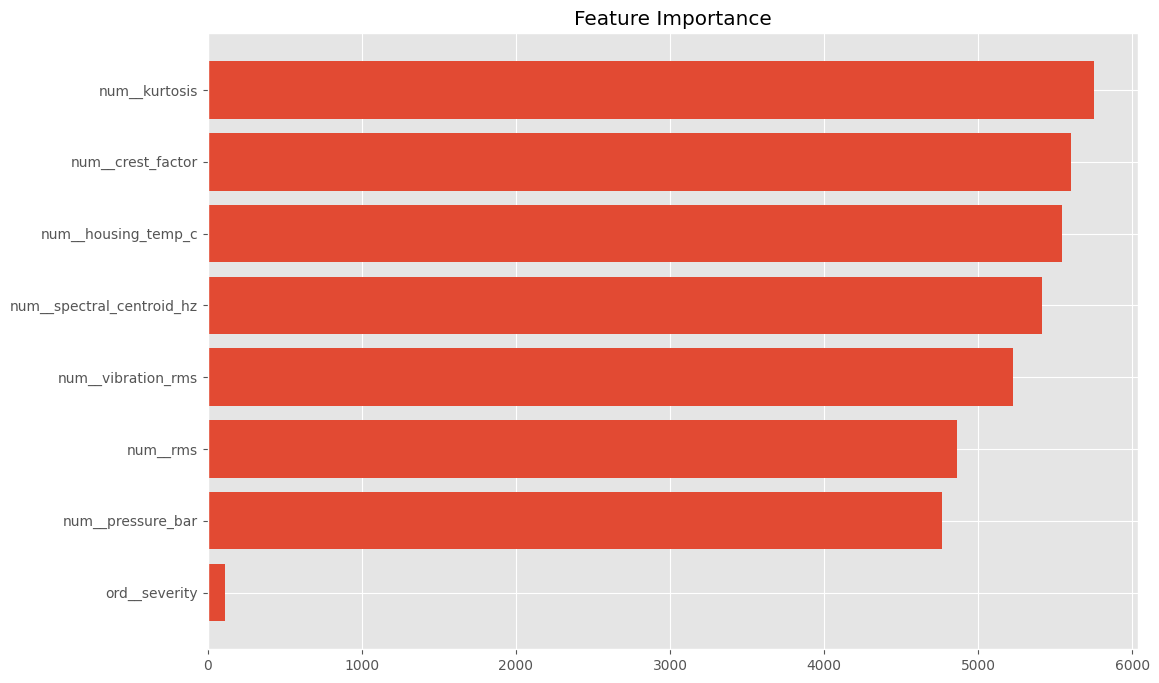

 has been saved succesfully.


['outputs_pm2/earlywarn_threshold.joblib']

In [42]:

X_fit = pd.concat([X_reg, X_clf], axis=0)
_ = prep.fit(X_fit)
Zreg = prep.transform(X_reg)
Zclf = prep.transform(X_clf)


reg_final = LGBMRegressor(**reg_kw).fit(Zreg, y_reg)
clf_final = LGBMClassifier(**clf_kw).fit(Zclf, y_clf, sample_weight=w_clf)






import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import RocCurveDisplay, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

import os
os.makedirs("viz", exist_ok=True)

counts = pd.Series(y_clf).value_counts().sort_index()
counts.plot(kind="bar", title="Target Class Distribution")
plt.show()
plt.savefig("viz/01_class_dist.png"); plt.close()

num = df.select_dtypes(include=["number"])
plt.imshow(num.corr(), aspect="auto")
plt.colorbar(); plt.title("Korealation")
plt.show()
plt.savefig("viz/02_corr_heatmap.png"); plt.close()

RocCurveDisplay.from_predictions(yL, pL)
plt.title("ROC Curve")
plt.show()
plt.savefig("viz/03_roc_curve.png"); plt.close()

prec, rec, _ = precision_recall_curve(yL, pL)
plt.plot(rec, prec); plt.title("Precision-Recall Curve")
plt.show()
plt.savefig("viz/04_pr_curve.png"); plt.close()

y_pred_best = (pL >= best_thr).astype(int)
cm = confusion_matrix(yL, y_pred_best)
disp = ConfusionMatrixDisplay(cm); disp.plot()
plt.title("Confusion Matrix")
plt.show()
plt.savefig("viz/05_conf_matrix.png"); plt.close()

imp = clf_final.feature_importances_
feat_names = prep.get_feature_names_out()
idx = np.argsort(imp)[-15:][::-1]
plt.barh(np.array(feat_names)[idx][::-1], imp[idx][::-1])
plt.title("Feature Importance")
plt.show()
plt.savefig("viz/06_feature_imp.png"); plt.close()

print(" has been saved succesfully.")


dump(prep, f"{OUT}/preprocessor.joblib")
dump(reg_final,  f"{OUT}/rul_lgbm.joblib")
dump(clf_final,  f"{OUT}/earlywarn_lgbm.joblib")
dump({"threshold":best_thr,"COST_FN":COST_FN,"COST_FP":COST_FP,"feature_names":list(X_clf.columns)}, f"{OUT}/earlywarn_threshold.joblib")

In [43]:

pd.DataFrame({
    "REG_MAE_mean":[float(np.mean(mae))], "REG_MAE_std":[float(np.std(mae))],
    "REG_MAPE_mean":[float(np.mean(mape))], "REG_MAPE_std":[float(np.std(mape))],
    "CLF_AP_mean":[float(np.mean(ap))], "CLF_AP_std":[float(np.std(ap))],
    "best_threshold":[best_thr], "cost_fn":[COST_FN], "cost_fp":[COST_FP],
    "n_features_reg":[int(Zreg.shape[1])], "n_features_clf":[int(Zclf.shape[1])],
    "n_samples_reg":[int(Zreg.shape[0])], "n_samples_clf":[int(Zclf.shape[0])]
}).to_csv(f"{OUT}/metrics_summary_pm2.csv", index=False)

plt.figure(); plt.plot(range(1,len(mae)+1), mae); plt.xlabel("Fold"); plt.ylabel("MAE"); plt.title("RUL MAE over folds")
plt.tight_layout(); plt.savefig(f"{OUT}/rul_mae_over_folds.png"); plt.close()

yte_last, yhat_last = last_reg
plt.figure(); plt.plot(yte_last, label="true RUL"); plt.plot(yhat_last, label="pred RUL")
plt.xlabel("Index (last fold)"); plt.ylabel("RUL"); plt.title("RUL prediction (last fold)"); plt.legend()
plt.tight_layout(); plt.savefig(f"{OUT}/rul_lastfold.png"); plt.close()

plt.figure(); plt.plot(R, P); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR curve (last fold)")
plt.tight_layout(); plt.savefig(f"{OUT}/earlywarn_pr_curve.png"); plt.close()

cm = confusion_matrix(yL, (pL>=best_thr).astype(int))
pd.DataFrame(cm, index=["true_0","true_1"], columns=["pred_0","pred_1"]).to_csv(f"{OUT}/earlywarn_confusion_at_best_thr.csv")
print(f"\n✅ Done. Artifacts → {OUT}/")



✅ Done. Artifacts → outputs_pm2/
